##### Mise en forme des dossiers de travail

In [1]:
!python --version

Python 3.8.12


In [2]:
import os
if os.getcwd().split('\\')[-1]!='OC-DS-P6-Classifiez-automatiquement-des-biens-de-consommation':
    # si valeur diff 'C:\\Users\\...\\Projets\\P6\\OC-DS-P6-Classifiez-automatiquement-des-biens-de-consommation'
    os.chdir('OC-DS-P6-Classifiez-automatiquement-des-biens-de-consommation')

In [3]:
#import tensorflow_core as tfc
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))#tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))#
print('la version de tensorflow est: ', tf.__version__)
#print('la version de tensorflow_core est: ', tfc.__version__)

Num GPUs Available:  0
Num GPUs Available:  0
la version de tensorflow est:  2.3.0


In [4]:
import pandas as pd
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')   

df['cat_1'] = df.product_category_tree.str.replace('\\[|\\"','',regex=True).str.split(" >> ",expand = True)[0]\
.apply(lambda x:x.replace(' ','_'))

In [5]:
IMAGE_SIZE = (224,224)
batch_size = 32
epochs = 25

train_path = 'data/cleaned/Images/train'
test_path  = 'data/cleaned/Images/test'
all_path   = 'data/cleaned/Images/all'

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

if not os.path.exists( train_path ): 
    os.makedirs( train_path )
    
if not os.path.exists( test_path ): 
    os.makedirs( test_path )

for repertoire in df.cat_1.unique():
    
    Xdf = df.loc[df.cat_1==repertoire]
    #print(df.iloc[i][['cat_1']].values[0])
    
    # Create the repositorys only if it doesn't existe yet
    for t in [train_path, test_path,all_path]:

        if not os.path.exists( t+'/'+"_".join(repertoire.split(' ')) ): 
            os.makedirs( t+'/'+"_".join(repertoire.split(' ')) )
    
    # create train test split
    X_train, X_test, y_train, y_test = train_test_split( Xdf[['image']], Xdf[['cat_1']], test_size=0.33, random_state=42)
    
    # resize and write .jpg train files
    for img in X_train.values:  
        image = Image.open('data/source/raw_folder_image/'+img[0]) 

        # Resizing image
        new_image = image.resize((224, 224))

        # Sauvegarde image format JPEG
        new_image.save(train_path+'/'+"_".join(repertoire.split(' '))+'/'+img[0],format = 'JPEG')
    
    # resize and write .jpg test files
    for img in X_test.values:  
        image = Image.open('data/source/raw_folder_image/'+img[0]) 

        # Resizing image
        new_image = image.resize((224, 224))

        # Sauvegarde image format JPEG
        new_image.save(test_path+'/'+"_".join(repertoire.split(' '))+'/'+img[0],format = 'JPEG')

        

## Utilisation du VGG-16 pré-entraîné

## Transfert Learning

In [7]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [8]:
VGG16(weights="imagenet", input_shape=(224, 224, 3)).summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :
for layer in model.layers:
   layer.trainable = False

In [12]:
import glob2
train_folders = glob2.glob(train_path+'/*')

# Récupérer la sortie de ce réseau et ajout d'une couche de Flatten 
flat1 = Flatten()(model.output)

class1 = Dense(1024, activation='relu')(flat1)

# Ajouter la nouvelle couche fully-connected pour la classification à 7 classes
predictions = Dense(len(train_folders), activation='softmax')(class1)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [13]:
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [15]:
# Compiler le modèle 
from keras import optimizers
# adam =optimizers.Adam()

new_model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), # adam
                  metrics=["accuracy"])




## Data Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


train_image_generator = ImageDataGenerator(
    rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_image_generator = ImageDataGenerator(rescale=1./255)

In [28]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           color_mode = "rgb",
                                                           directory= train_path,
                                                           shuffle=True,
                                                           target_size=IMAGE_SIZE, 
                                                           class_mode='categorical',
                                                           save_to_dir='data/cleaned/Images/augmented images train/',
                                                           save_prefix='augm_',
                                                            save_format='jpg',
                                                          )

val_data_gen = test_image_generator.flow_from_directory(batch_size = batch_size, 
                                                              directory = test_path, 
                                                              color_mode = 'rgb',
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='categorical')


Found 700 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


## Entrainement

In [29]:
%%time
new_model.fit_generator(train_data_gen, 
                    epochs=epochs,  # one forward/backward pass of training data
                    steps_per_epoch=700 //batch_size,  # number of images comprising of one epoch
                    validation_data=val_data_gen, # Or validation_data=valid_generator
                    validation_steps= 350 //batch_size)


Epoch 1/25
21/21 [==============================] - 54s 3s/step - loss: 1.9773 - accuracy: 0.1737 - val_loss: 1.8107 - val_accuracy: 0.2906
Epoch 2/25
21/21 [==============================] - 55s 3s/step - loss: 1.7875 - accuracy: 0.2874 - val_loss: 1.5744 - val_accuracy: 0.4344
Epoch 3/25
21/21 [==============================] - 55s 3s/step - loss: 1.6344 - accuracy: 0.4521 - val_loss: 1.4722 - val_accuracy: 0.4781
Epoch 4/25
21/21 [==============================] - 55s 3s/step - loss: 1.5479 - accuracy: 0.4431 - val_loss: 1.3398 - val_accuracy: 0.5406
Epoch 5/25
21/21 [==============================] - 55s 3s/step - loss: 1.4362 - accuracy: 0.5240 - val_loss: 1.2877 - val_accuracy: 0.5625
Epoch 6/25
21/21 [==============================] - 56s 3s/step - loss: 1.3505 - accuracy: 0.5719 - val_loss: 1.1756 - val_accuracy: 0.6156
Epoch 7/25
21/21 [==============================] - 56s 3s/step - loss: 1.2910 - accuracy: 0.5763 - val_loss: 1.1722 - val_accuracy: 0.6094
Epoch 8/25
21/21 [==

Text(0.5, 0, 'Epoch')

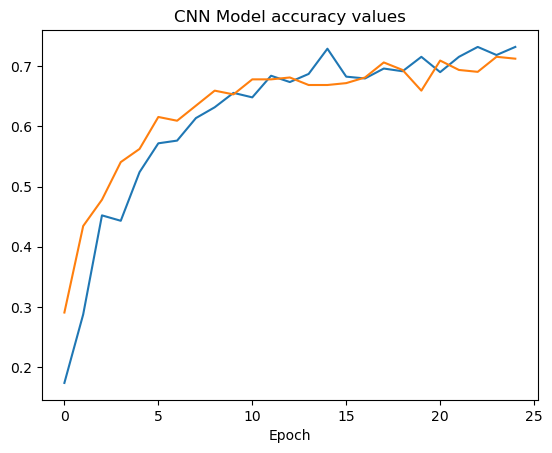

In [35]:
import matplotlib.pyplot as plt
plt.plot(new_model.history.history['accuracy'])
plt.plot(new_model.history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.xlabel('Epoch')

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2).